------epoch 1-------
------epoch 2-------
------epoch 3-------
------epoch 4-------
------epoch 5-------
------epoch 6-------
------epoch 7-------
------epoch 8-------
------epoch 9-------
------epoch 10-------
------epoch 11-------
------epoch 12-------
------epoch 13-------
------epoch 14-------
------epoch 15-------
------epoch 16-------
------epoch 17-------
------epoch 18-------
------epoch 19-------
------epoch 20-------
------epoch 21-------
------epoch 22-------
------epoch 23-------
------epoch 24-------
------epoch 25-------
------epoch 26-------
------epoch 27-------
------epoch 28-------
------epoch 29-------
------epoch 30-------
------epoch 31-------
------epoch 32-------
------epoch 33-------
train_accuracy_output.txt文件保存完毕!
test_accuracy_output.txt文件保存完毕!


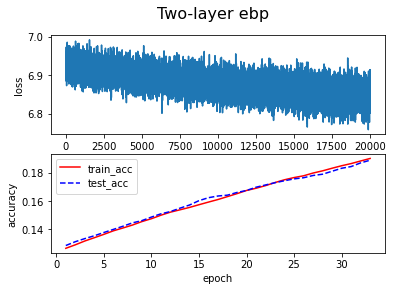

In [33]:
#ch04.05，page 110 随机梯度下降法
#%load_ext autoreload
#%autoreload 2
#%aimport functions_methods
import sys, os
#sys.path.append(os.pardir) #将父目录（上一级）os.pardir添加到系统搜索路径
#print(os.pardir) # 输出‘..’
import numpy as np
import matplotlib.pylab as plt
import layers_error_back_propogation as lebp
from mpl_toolkits.mplot3d import axes3d
import functions_methods as fm
from dataset.mnist import load_mnist #在上一级中搜索dataset文件夹（模块）并得到其中mnist.py文件
from PIL import Image
from collections import OrderedDict
#import imp 
#imp.reload(functions_methods)
#imp.reload(layers_error_back_propogation)
#初始化两层网络
class TwoLayerNet_ebp:

    def __init__(self, input_size, hidden_size,output_size, weight_init_std=0.01):
        #初始化参数
        self.params={}
        #self.params['w1']=weight_init_std*np.random.randn(input_size,hidden_size)
        #self.params['w1']=np.random.randn(input_size,hidden_size)*2**0.5/np.sqrt(input_size) #He初值
        self.params['w1']=np.random.randn(input_size,hidden_size)/np.sqrt(input_size)#Xavier初值
        self.params['b1']=np.zeros(hidden_size)
        #self.params['w2']=weight_init_std*np.random.randn(hidden_size,output_size)
        #self.params['w2']=np.random.randn(hidden_size,output_size)*2**0.5/np.sqrt(hidden_size)
        self.params['w2']=np.random.randn(hidden_size,output_size)/np.sqrt(hidden_size)
        self.params['b2']=np.zeros(output_size)
        
        #生成顺序层 
        self.layers=OrderedDict()
        self.layers['Affine1']=lebp.Affine_layer(self.params['w1'],self.params['b1']) #传入__init__所需参数
        self.layers['ReLU1']=lebp.ReLU_layer()
        self.layers['Affine2']=lebp.Affine_layer(self.params['w2'],self.params['b2'])
        self.lastlayer=lebp.SoftmaxWithLoss()
        
    def predict(self, x):
        for layers in self.layers.values():
            x=layers.forward(x)
        return x
    
    def loss(self, x, t):
        y=self.predict(x)
        return self.lastlayer.forward(y,t)
    
    def accuracy(self, x, t):
        y=self.predict(x)
        y=np.argmax(y, axis=1)
        if t.ndim!=1:
            t=np.argmax(t, axis=1)  #one-hot-label为True时，t的shape为（60000,10）
        accuracy=np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t):
        #forward
        self.loss(x,t)
        
        #backward
        dout=1
        dout=self.lastlayer.backward(dout)
        layers=list(self.layers.values())
        layers.reverse()
        
        for l in layers:
            dout=l.backward(dout)
        
        #将更新过的参数值
        grads={}
        grads['w1']=self.layers['Affine1'].dw
        grads['b1']=self.layers['Affine1'].db
        grads['w2']=self.layers['Affine2'].dw
        grads['b2']=self.layers['Affine2'].db
        
        return grads

    
#mini-batch 学习过程

#1.载入训练数据和正确解标签
(x_train, t_train), (x_test, t_test)=load_mnist(normalize=True, one_hot_label=True)

#x_train, t_train=x_train[0:5000],t_train[0:5000]
#x_test, t_test=x_test[0:1000], t_test[0:1000]

#2.初始化超参数
num_learn=20000
train_size= x_train.shape[0] #60000
batch_size=100
learning_rate=0.00001
network=TwoLayerNet_ebp(input_size=784, hidden_size=50, output_size=10)
epoch=max(train_size/batch_size,1) #不足1的，按1算
num_epoch=int(num_learn/epoch)
train_loss_list=[]
train_accuracy_list=[]
test_accuracy_list=[]
c=1 
#3.学习
for i in range(num_learn):
    #随机获取第i次学习的mini-batch下标
    batch_mask= np.random.choice(train_size,batch_size)
    #通过下标获取此次训练batch
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #用反向传播法计算当前损失函数对于权重w和偏置b的梯度
    grad=network.gradient(x_batch,t_batch)
    
    #根据梯度下降法stochastic gradient descent来更新权重w和偏置b
    for key in ('w1','b1','w2','b2'):
        network.params[key]-=learning_rate*grad[key]
        
    #记录损失函数在更新参数时的变化过程
    loss=network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
   # print("------------learning step:{}-----------".format(i))
    
    if i % epoch == 0 and i != 0:
        print("------epoch {}-------".format(c))
        c+=1
        train_accuracy=network.accuracy(x_train,t_train) #用此epoch训练的self.params预测整个训练数据集时的准确率
        test_accuracy=network.accuracy(x_test,t_test)  #用此epoch训练的self.params预测整个测试数据集时的准确率
       # train_loss_list.append(loss)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        
#将准确率变化数据写入txt文件   
fm.write_txt_data('train_accuracy_output.txt','w',train_accuracy_list)
fm.write_txt_data('test_accuracy_output.txt','w',test_accuracy_list)
#损失函数、训练/测试准确率变化过程可视化
plt.subplot(2,1,1)
plt.xlabel('iteration')
plt.ylabel('loss')
#plt.title('Loss function')
x1=np.arange(1,num_learn+1,1)
#x2=np.arange(1,num_epoch+1,1)
plt.plot(x1,train_loss_list,label='Loss function')

plt.subplot(2,1,2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
x2=np.arange(1,num_epoch+1,1)
plt.plot(x2,train_accuracy_list,color='r',linestyle='-',label='train_acc')
plt.plot(x2,test_accuracy_list,color='b',linestyle='--',label='test_acc')
plt.legend()

Title=plt.suptitle('Two-layer ebp', fontsize=16)
Title.set_color('k')
plt.savefig(fname='/Users/huangjing/Documents/GitHub/DL/a-practise/2-layer-ebp.png',dpi=600)
plt.show()

        
        
#try:    
#    !jupyter nbconvert --to python 3layered_neural_network_forward.ipynb
#    # python即转化为.py，script即转化为.html
#except:
#    pass
